<a href="https://colab.research.google.com/github/barotmanav/Hybrid-model/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:43:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Hybrid Model Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       203
           1       0.98      0.98      0.98       189

    accuracy                           0.98       392
   macro avg       0.98      0.98      0.98       392
weighted avg       0.98      0.98      0.98       392

Hybrid Model Accuracy: 0.98


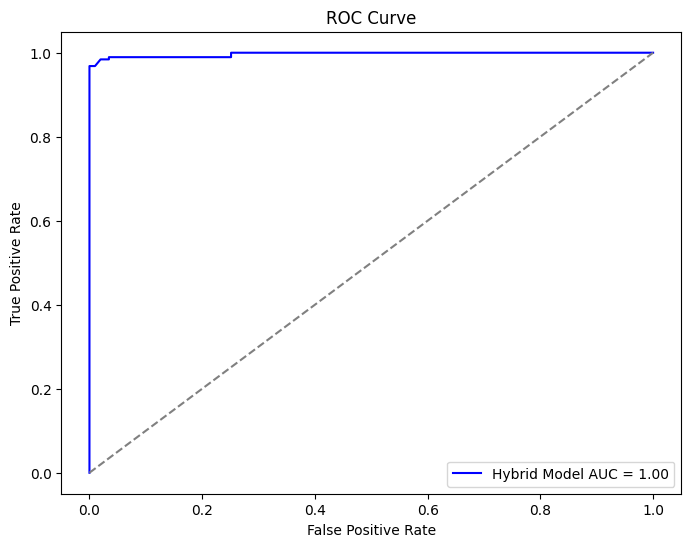

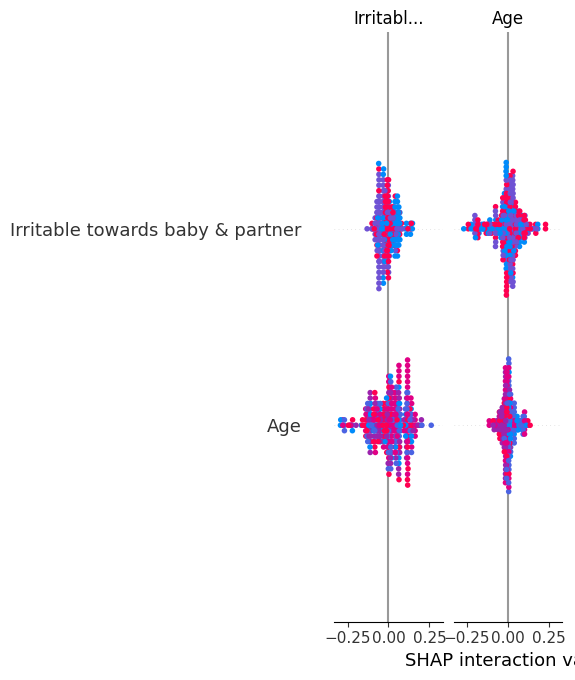

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE  # Handle class imbalance

# Load the dataset
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/post natal data.csv")

data_cleaned = data.drop(columns=['Timestamp'])

# Encode categorical data
encoder = LabelEncoder()
for column in data_cleaned.columns:
    data_cleaned[column] = data_cleaned[column].fillna('Unknown')
    data_cleaned[column] = encoder.fit_transform(data_cleaned[column])

# Define features (X) and target (y)
X = data_cleaned.drop(columns=['Feeling sad or Tearful'])
y = (data_cleaned['Feeling sad or Tearful'] > 0).astype(int)  # Convert to binary

# Handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Hyperparameter tuning
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

# Predictions
y_pred_rf = best_rf.predict_proba(X_test)[:, 1]
y_pred_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_logistic = logistic_model.predict_proba(X_test)[:, 1]

# Hybrid model
weights = [0.4, 0.4, 0.2]
ensemble_pred = (weights[0] * y_pred_rf + weights[1] * y_pred_xgb + weights[2] * y_pred_logistic)
ensemble_pred_class = (ensemble_pred >= 0.5).astype(int)

# Evaluation
print("Hybrid Model Classification Report:\n", classification_report(y_test, ensemble_pred_class))
accuracy_ensemble = accuracy_score(y_test, ensemble_pred_class)
print(f"Hybrid Model Accuracy: {accuracy_ensemble:.2f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, ensemble_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Hybrid Model AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Save model using pickle
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(best_rf, f)
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)
with open("logistic_model.pkl", "wb") as f:
    pickle.dump(logistic_model, f)

# SHAP Explainability
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
